## 0. Packages

In [ ]:
import os
import re
import urllib
import numpy as np
import pandas as pd
from math import nan
import nltk
import seaborn as sns
import spacy
import en_core_web_sm
from spacy import displacy
import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from wordcloud import WordCloud, STOPWORDS
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import statistics
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import random
import torch
from torch.utils.data import DataLoader
from torch.optim import SGD, Adam
from tqdm import tqdm
!pip install transformers
from transformers import BertTokenizerFast
from transformers import BertForTokenClassification
from sklearn.decomposition import NMF
import warnings
warnings.filterwarnings('ignore')

## Function for Importing

In [ ]:
CONLL_URL_ROOT = "https://github.com/nluninja/nlp_datasets/tree/main/GUM/data"
#CONLL_URL_ROOT = "https://github.com/nluninja/nlp_datasets/blob/main/GUM/data/"


In [ ]:
def open_read_from_url(url):
    """
    Take in input an url to a .txt file and return the list of its raws
    """
    print(f"Read file from {url}")
    file = urllib.request.urlopen(url)
    lines = []
    for line in file:
        lines.append(line.decode("utf-8"))

    return lines

In [ ]:
def read_raw_conll(url_root, dir_path, filename):
    """Read a file which contains a conll03 dataset"""
    lines = []
    path = os.path.join(dir_path, filename)
    full_url = url_root + filename
    if os.path.isfile(path):
        # read from file
        print(f'Reading file {path}')
        with open(path, 'r') as f:
            lines = f.readlines()
    else:
        lines = open_read_from_url(full_url)
    return lines[1:]

In [ ]:
def is_real_sentence(only_token, sentence):
    """Chek if a sentence is a real sentence or a document separator"""
    first_word = ""
    if only_token:
        first_word = sentence[0]
    else:
        first_word = sentence[0][0]

    if '---------------------' in first_word or first_word == '-DOCSTART-':
        return False
    else:
        return True

In [ ]:
def load_conll_data(filename, url_root=CONLL_URL_ROOT, dir_path='',
                    only_tokens=False):
    """
    Take an url to the raw .txt files that you can find the repo linked above,
    load data and save it into a list of tuples data structure.

    Those files structure data with a word in each line with word, POS,
    syntactic tag and entity tag separated by a whitespace. Sentences are
    separated by an empty line.
    """
    lines = read_raw_conll(url_root, dir_path, filename)
    X = []
    Y = []
    sentence = []
    labels = []
    output_labels=set()
    for line in lines:
        if line == "\n":
            if(len(sentence) != len(labels)):
                print(f"Error: we have {len(sentence)} words but {len(labels)} labels")
            if sentence and is_real_sentence(only_tokens, sentence):
                X.append(sentence)
                Y.append(labels)
            sentence = []
            labels = []
        else:
            features = line.split()
            tag = features.pop()
            labels.append(tag)
            output_labels.add(tag)
            if only_tokens:
                sentence.append(features.pop(0))
            else:
                sentence.append(tuple(features))

    print(f"Read {len(X)} sentences")
    if(len(X) != len(Y)):
        print("ERROR in reading data.")
    return X, Y, output_labels

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Importing Dataset

The purpose of this project is to analyze the Georgetown University Multilayer (**GUM**) Corpus  coming from this [repo](https://github.com/nluninja/nlp_datasets/tree/main/GUM), that contains two columns:

- token
- ner_tag

This [corpus](https://github.com/amir-zeldes/gum) contains English texts from twelve written and spoken text types:
- interviews
- news
- travel guides
- how-to guides
- academic writing
- biographies
- fiction
- online forum discussions
- spontaneous face to face conversations
- political speeches
- textbooks
- vlogs

Our goal is to classify correctly the 23 classes coming from the **ner_tag** through a **BILSTM** and **Bert Model**




In [ ]:
data_dir = os.path.join('/content/drive/MyDrive/data')
raw_train, ner_train, output_labels = load_conll_data('gum-train.conll', dir_path=data_dir, only_tokens=True)
raw_test, ner_test, _ = load_conll_data('gum-test.conll', dir_path=data_dir, only_tokens=True)

Reading file /content/drive/MyDrive/data/gum-train.conll
Read 2494 sentences
Reading file /content/drive/MyDrive/data/gum-test.conll
Read 999 sentences


In [ ]:
print(raw_train[0])
print(ner_train[0])

['The', 'back', 'of', 'my', 'jersey', 'says', '"', 'The', 'Poet', "'", 'because', 'growing', 'up', 'that', 'was', 'my', 'nickname', '.']
['B-object', 'I-object', 'I-object', 'I-object', 'I-object', 'O', 'B-abstract', 'I-abstract', 'I-abstract', 'I-abstract', 'O', 'O', 'O', 'B-abstract', 'O', 'B-person', 'O', 'O']


In [ ]:
print(raw_train[-1],ner_train[-1])

['Wednesday', ',', 'October', '3', ',', '2007'] ['B-time', 'I-time', 'I-time', 'I-time', 'I-time', 'I-time']


**Two ways of see the dataset**

In [ ]:
sentence_data = pd.DataFrame({'Sentence': raw_train})
sentence_data['Sentence'] = [' '.join(map(str, l)) for l in sentence_data['Sentence']]
sentence_data

,Sentence
0,"The back of my jersey says "" The Poet ' becaus..."
1,"These hotels may not be the most luxerious , b..."
2,Henga Scenic Reserve .
3,It costs us so much money to for us to travel ...
4,Tulsa has over 225 days of sunshine annually .
...,...
2489,"Come and have a look at this statue , erected ..."
2490,""" If an infant 's not getting enough iodine ....."
2491,If you cannot go to the Cuban Consulate you ma...
2492,Steps


In [ ]:
def flatten_list(_2d_list):
    flat_list = []
    # Iterate through the outer list
    for element in _2d_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list


train_new = flatten_list(raw_train)
ner_new = flatten_list(ner_train)

In [ ]:
ner_data = pd.DataFrame(
    {'Word': train_new,
     'Tag': ner_new
    })

In [ ]:
ner_data

,Word,Tag
0,The,B-object
1,back,I-object
2,of,I-object
3,my,I-object
4,jersey,I-object
...,...,...
44085,",",I-time
44086,October,I-time
44087,3,I-time
44088,",",I-time


In [ ]:
ner_data['Tag'].value_counts()
# the count of each class

O                 20442
I-abstract         4687
I-event            2707
I-place            2212
B-abstract         2002
B-person           1919
I-person           1866
I-object           1731
B-place            1150
B-object           1016
B-event             738
I-time              663
I-organization      552
I-substance         458
B-time              401
B-organization      397
B-substance         278
I-quantity          203
I-plant             166
B-plant             144
B-animal            141
I-animal            120
B-quantity           97
Name: Tag, dtype: int64

## 2. Topic Modelling

### 2.1 LDA

 <img src="https://user-images.githubusercontent.com/103529789/207368819-1f391c80-ee6c-44e3-ba38-841634a5522f.PNG" width="700"/>

**Procedure**
- For every word in every document and for each Topic T we calculate:
$P(Topic \ T | Document\ D)$ = the proportion of words in document d that are currently assign to topic T
- $P(Word \ W | Topic \ T)$ = the proportion of assignments to topic T over all documents that come from this word W
- Reassign w to a new topic where we choose Topic T with probability $P(Topic \ T | Document \ D)$ * $P(Word \ W | Topic \ T)$.This is essentially that Topic T generated word w
- After repeating the previous step large number of times, we eventually reach a roughly steady state where the assignments are acceptable. At the end we have each document assigned to a topic. We can search for the words that have highest probability of being assigned to a topic.

In [ ]:
data_topic = pd.DataFrame({'Sentence': raw_train})
data_topic['Sentence'] = [' '.join(map(str, l)) for l in data_topic['Sentence']]
data_topic

,Sentence
0,"The back of my jersey says "" The Poet ' becaus..."
1,"These hotels may not be the most luxerious , b..."
2,Henga Scenic Reserve .
3,It costs us so much money to for us to travel ...
4,Tulsa has over 225 days of sunshine annually .
...,...
2489,"Come and have a look at this statue , erected ..."
2490,""" If an infant 's not getting enough iodine ....."
2491,If you cannot go to the Cuban Consulate you ma...
2492,Steps


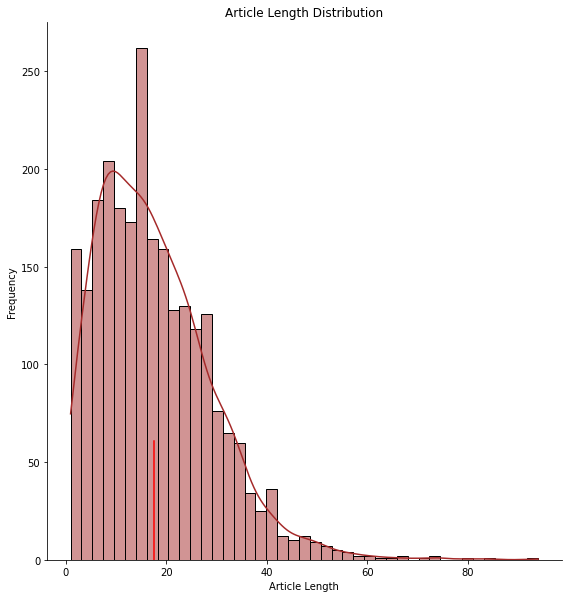

In [ ]:
data_topic["Words_Per_Article"] = data_topic["Sentence"].str.split().apply(len)
n_words_list = data_topic['Words_Per_Article'].values.tolist()

word_mean = statistics.mean(n_words_list)
sns.displot(n_words_list, height = 8, kind = "hist", kde = True,color='brown')
plt.title("Article Length Distribution")
plt.xlabel("Article Length")
plt.ylabel("Frequency")

plt.plot([word_mean, word_mean], [0, 61], color = "r")

del data_topic['Words_Per_Article']

CountVectorizer means breaking down a sentence of a text into words by performing preprocessing tasks. Therefore, using this function we'd like to count the occurances of words in our document.

In [ ]:
cv = CountVectorizer(stop_words='english')
dtm = cv.fit_transform(data_topic['Sentence'])
dtm
dtm_feature_names = cv.get_feature_names()

In [ ]:
dtm_feature_names = cv.get_feature_names()

Due to the fact that our dataset is composed by 193 different documents, after many trials, we have decided to fit our corpus into twelve topics.

In [ ]:
LDA = LatentDirichletAllocation(n_components=12,random_state=42)

In [ ]:
LDA.fit(dtm)

LatentDirichletAllocation(n_components=12, random_state=42)

After that, we show the stored words and we display the top ten words for each topics and the corrisponding weights.

In [ ]:
len(cv.get_feature_names())

6751

In [ ]:
LDA.components_

array([[0.08333333, 2.08332888, 0.08333333, ..., 0.08333333, 3.08334195,
        1.08333333],
       [0.08333333, 1.08332769, 0.08333333, ..., 1.08333333, 1.08332658,
        0.08333333],
       [0.08333333, 0.08333333, 1.08333333, ..., 0.08333333, 1.08332512,
        0.08333333],
       ...,
       [0.08333333, 6.08335159, 0.08333333, ..., 0.08333333, 1.08332908,
        0.08333333],
       [0.08333333, 5.08334513, 0.08333333, ..., 0.08333333, 2.08333656,
        0.08333333],
       [0.08333333, 2.08333901, 0.08333333, ..., 0.08333333, 0.08333333,
        0.08333333]])

In [ ]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [ ]:
no_top_words = 10
display_topics(LDA, dtm_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,...,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights,Topic 10 words,Topic 10 weights,Topic 11 words,Topic 11 weights
0,make,10.8,space,21.8,method,14.3,good,28.8,scientology,20.9,...,santorum,16.9,friends,10.7,new,10.3,like,25.7,people,12.7
1,remember,8.1,warhol,15.8,make,13.3,image,12.1,people,17.7,...,did,11.1,history,9.0,city,8.7,new,22.7,like,11.8
2,know,6.1,shuttle,15.1,new,10.4,like,12.1,joke,17.1,...,world,10.1,does,8.9,time,7.1,people,10.7,understand,11.1
3,home,6.1,center,11.6,time,9.9,want,10.7,way,16.6,...,party,10.0,chicken,7.7,beavertail,7.1,said,10.1,language,10.1
4,sure,6.1,new,11.3,just,9.1,vodka,10.6,image,15.9,...,wikinews,8.8,people,7.4,people,7.1,city,9.7,beautiful,9.1
5,hand,6.1,andy,11.1,floor,9.1,skittles,10.2,know,14.0,...,play,8.5,ll,7.1,land,6.1,york,9.1,city,9.0
6,days,5.1,program,10.1,wikihow,8.1,place,10.2,like,12.0,...,quidditch,8.1,magic,7.1,instead,6.1,zealand,9.0,think,8.6
7,questions,5.1,party,9.1,ants,8.1,main,10.0,moreau,10.1,...,people,8.1,long,6.1,000,6.1,including,8.1,fun,7.1
8,use,4.9,fort,9.1,want,7.5,way,9.2,nick,10.1,...,city,8.1,kind,6.1,writers,6.1,world,7.2,use,7.0
9,time,4.7,lee,9.1,like,7.4,plants,8.9,came,9.1,...,cocktail,7.7,month,5.9,cuttings,6.1,salt,7.1,group,6.9


As we said, we have many documents, therefore it's hard to find specific topics. However, we can notice some coherence among the words, for example perhaps topic n.1 has to do with art and space, topic n.2 with food, topic n.11 with language.

Then, we choose the most likely topic for every document.

In [ ]:
topic_results = LDA.transform(dtm)
topic_results.shape
argmax = topic_results.argmax(axis=1)
argmax = list(argmax)

In [ ]:
data_topic['Topic'] = argmax
data_topic.head()

,Sentence,Topic
0,"The back of my jersey says "" The Poet ' becaus...",6
1,"These hotels may not be the most luxerious , b...",8
2,Henga Scenic Reserve .,4
3,It costs us so much money to for us to travel ...,8
4,Tulsa has over 225 days of sunshine annually .,2


Using a bar plot, we would like to show the frequency of each topic. It is noticeable, that the most frequent topic is the number five, while the others are almost uniformally distributed.

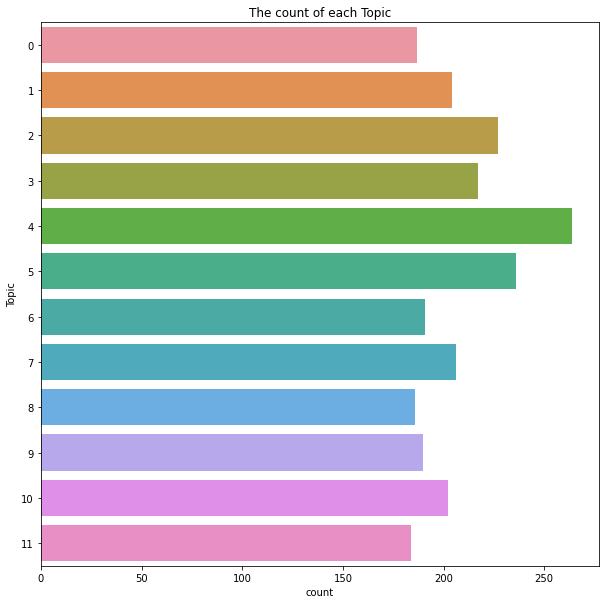

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(y='Topic', data=data_topic).set(title='The count of each Topic')
plt.show()

### 2.2 NMF

Non-negative Matrix Factorization (NMF) is an unsupervised algorithm that simultaneously performs dimensionality reduction and clustering.
NMF takes advantage of the fact that the vectors are non-negative. NMF differs from LDA for the fact that tokens are vectorized and it follows a TF-IDF (term-frequence/inverse term-frequence paradigm).

Procedure:


*   Given a non-negative matrix A, find k-
dimension approximation in terms of non-
negative factors W and H, where $A=W*H$
*   Approximate each object (i.e. column of A)
by a linear combination of k reduced
dimensions or “basis vectors” in W.


*   Each basis vector can be interpreted as a
cluster. The memberships of objects in
these clusters encoded by H.


*   Just like LDA, we will need to select the
number of expected topics beforehand and we need to interpret the topics based of the coefficient values of the words per topic.

In [ ]:
npr = pd.DataFrame({'Sentence': raw_train})
npr['Sentence'] = [' '.join(map(str, l)) for l in npr['Sentence']]
npr

,Sentence
0,"The back of my jersey says "" The Poet ' becaus..."
1,"These hotels may not be the most luxerious , b..."
2,Henga Scenic Reserve .
3,It costs us so much money to for us to travel ...
4,Tulsa has over 225 days of sunshine annually .
...,...
2489,"Come and have a look at this statue , erected ..."
2490,""" If an infant 's not getting enough iodine ....."
2491,If you cannot go to the Cuban Consulate you ma...
2492,Steps


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
dtm = tfidf.fit_transform(npr['Sentence'])
dtm

<2494x6751 sparse matrix of type '<class 'numpy.float64'>'
	with 18865 stored elements in Compressed Sparse Row format>

In [ ]:
tfidf = TfidfVectorizer(stop_words='english')
dtm = tfidf.fit_transform(npr['Sentence'])
dtm

<2494x6751 sparse matrix of type '<class 'numpy.float64'>'
	with 18865 stored elements in Compressed Sparse Row format>

In [ ]:
tfidf_feature_names = tfidf.get_feature_names()

As we did in LDA model, we choose twelve topics and we view the model dimension.

In [ ]:
nmf_model = NMF(n_components=12,random_state=42)
nmf_model.fit(dtm)

NMF(n_components=12, random_state=42)

In [ ]:
nmf_model.components_

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.18088668, 0.        , ..., 0.        , 0.02249599,
        0.        ],
       ...,
       [0.        , 0.        , 0.00155565, ..., 0.        , 0.00489019,
        0.        ],
       [0.00061292, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
no_top_words = 10
display_topics(nmf_model, tfidf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,...,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights,Topic 10 words,Topic 10 weights,Topic 11 words,Topic 11 weights
0,image,1.3,understand,1.9,people,2.4,know,1.5,make,1.3,...,interview,1.7,like,1.5,world,0.8,method,0.8,joke,1.2
1,moreau,0.9,language,0.1,arrogant,0.6,remember,0.1,sure,0.6,...,wikinews,0.1,language,0.3,think,0.6,place,0.5,start,0.5
2,nick,0.9,fun,0.1,fun,0.4,audience,0.1,did,0.3,...,chomsky,0.1,just,0.2,good,0.4,vodka,0.4,want,0.4
3,nasa,0.3,candidates,0.1,way,0.2,simpson,0.1,ll,0.2,...,political,0.1,want,0.2,cup,0.3,quinoa,0.3,use,0.3
4,david,0.1,success,0.1,talk,0.2,write,0.1,language,0.2,...,america,0.1,mathematics,0.2,beautiful,0.3,basil,0.3,talk,0.1
5,shankbone,0.1,party,0.0,000,0.2,did,0.1,floor,0.2,...,interviewed,0.1,wash,0.2,scientology,0.2,skittles,0.3,small,0.1
6,warhol,0.1,communicate,0.0,detect,0.1,way,0.1,pockets,0.1,...,frank,0.1,sky,0.1,said,0.2,water,0.3,file,0.1
7,jambula,0.1,friends,0.0,charm,0.1,answer,0.1,skittles,0.1,...,messina,0.1,insane,0.1,really,0.2,bottle,0.2,crucial,0.1
8,snbehnke,0.1,soon,0.0,look,0.1,year,0.1,vodka,0.1,...,noam,0.1,bit,0.1,called,0.2,cupcakes,0.2,probably,0.1
9,andy,0.0,past,0.0,group,0.1,tires,0.1,use,0.1,...,month,0.1,little,0.1,quality,0.2,cuttings,0.2,game,0.1


In [ ]:
topic_results = nmf_model.transform(dtm)
topic_results.shape
topic_results[0]
topic_results[0].argmax()

5

In [ ]:
topic_results.argmax(axis=1)
npr['Topic'] = topic_results.argmax(axis=1)

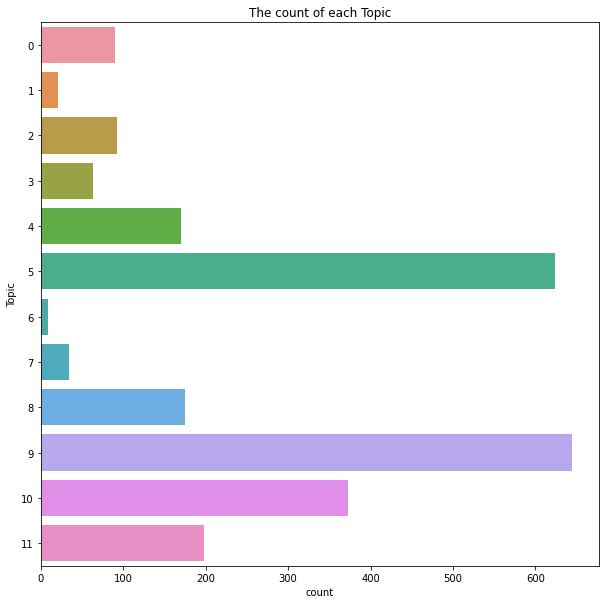

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(y='Topic', data=npr).set(title='The count of each Topic')
plt.show()

In NMF model we view a considerable difference in the distribution of each topic, with respect to the LDA model.
While in LDA the topics were almost uniformly distrubuted, here we can notice that  most of the documents are linked to the topic n.5 and n.9 and a less featured are topic n.1 and topic n.6.

## 3. EDA


### 3.1 Bar Chart

Here “B” denotes beginning of an entity, “I” stands for “inside” and is used for all words comprising the entity except the first one, and “O” means the absence of entity.

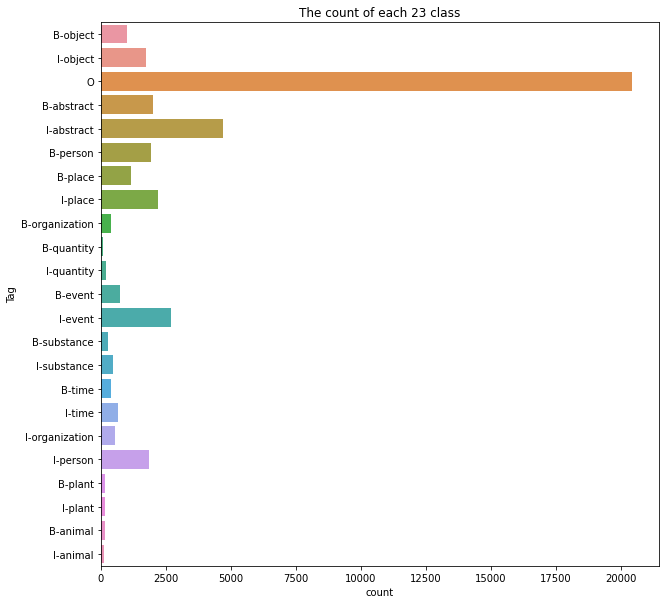

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(y='Tag', data=ner_data).set(title='The count of each 23 class')
plt.show()

### 3.2 Word Cloud

In [ ]:
t= str(train_new)

In [ ]:
testo=" ".join(train_new)

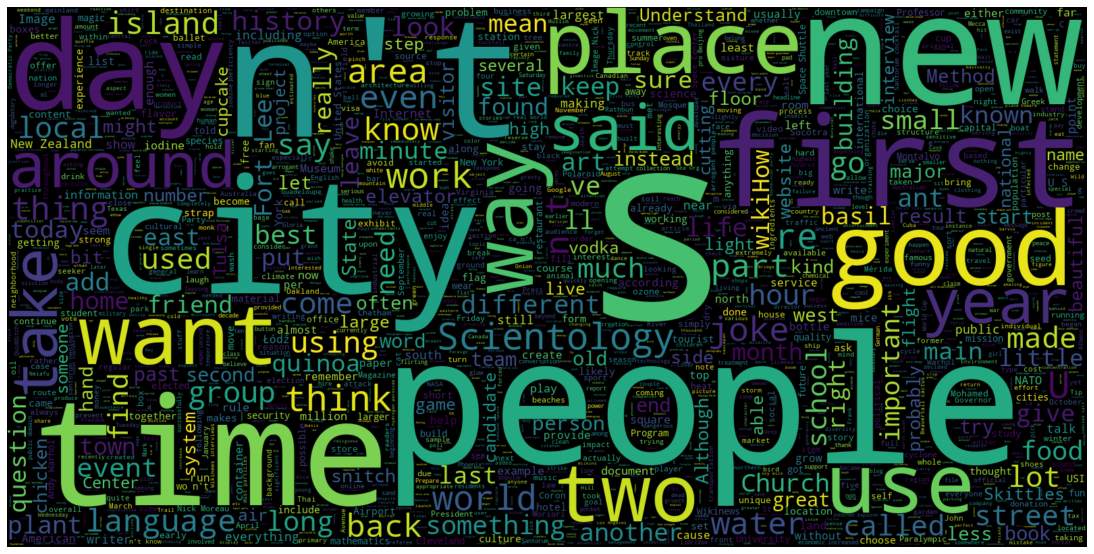

In [ ]:
stopwords = ['many','one','will','may','see','make','well']+ list(STOPWORDS)
testo2 = WordCloud(
    background_color='black',
    max_words=2000,
    stopwords=stopwords,
    width=1600, height=800
)
# generate the word cloud
testo2.generate(testo)

# display the word cloud
plt.figure( figsize=(15,15))
plt.imshow(testo2, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### 3.3 NER

In [ ]:
nlp = en_core_web_sm.load()
doc = nlp(testo)

In [ ]:
displacy.render(doc, style='ent', jupyter=True)

In [ ]:
entities = []
labels = []
position_start = []
position_end = []
description= []

for ent in doc.ents:
    entities.append(ent)
    labels.append(ent.label_)
    position_start.append(ent.start_char)
    position_end.append(ent.end_char)
    description.append(str(spacy.explain(ent.label_)))

df = pd.DataFrame({'Entities':entities,'Labels':labels,'Position_Start':position_start, 'Position_End':position_end,'Description':description})

df

,Entities,Labels,Position_Start,Position_End,Description
0,"(The, Poet, ')",WORK_OF_ART,29,39,"Titles of books, songs, etc."
1,"(Henga, Scenic, Reserve)",ORG,221,241,"Companies, agencies, institutions, etc."
2,(Tulsa),GPE,332,337,"Countries, cities, states"
3,"(225, days)",DATE,347,355,Absolute or relative dates or periods
4,(annually),DATE,368,376,Absolute or relative dates or periods
...,...,...,...,...,...
2868,(1985),DATE,229863,229867,Absolute or relative dates or periods
2869,"(the, Cuban, Consulate)",LOC,230245,230264,"Non-GPE locations, mountain ranges, bodies of ..."
2870,(VisaCuba),GPE,230288,230296,"Countries, cities, states"
2871,(3),CARDINAL,230301,230302,Numerals that do not fall under another type


## 4. Feature Engineering

### 4.1 Token Ordinal Encoding

An ordinal encoding involves mapping each unique label to an integer value.

In [ ]:
# integer encode sequences of words
token_tokenizer = Tokenizer()    # Automatically lowers tokens
token_tokenizer.fit_on_texts(raw_train + raw_test)
train_sequences = token_tokenizer.texts_to_sequences(raw_train)
test_sequences = token_tokenizer.texts_to_sequences(raw_test)

tag2idx = { tag: idx for idx, tag in enumerate(output_labels) }
idx2tag = { idx: tag for tag, idx in tag2idx.items() }
ner_train_sequences = [[tag2idx[tag] for tag in sentence] for sentence in ner_train]
ner_test_sequences  = [[tag2idx[tag] for tag in sentence] for sentence in ner_test ]

In [ ]:
print(raw_test[5])
print(test_sequences[5])
for i in test_sequences[5]:
    print(f'{i} : {token_tokenizer.index_word[i]}')

['If', 'Keeper', 'is', 'close', 'to', 'their', 'hoops', 'they', 'are', 'safe', 'from', 'being', 'hit', 'by', 'bludgers', '.']
[36, 4116, 9, 489, 6, 57, 2583, 32, 18, 855, 21, 170, 767, 31, 1024, 2]
36 : if
4116 : keeper
9 : is
489 : close
6 : to
57 : their
2583 : hoops
32 : they
18 : are
855 : safe
21 : from
170 : being
767 : hit
31 : by
1024 : bludgers
2 : .


In [ ]:
vocabulary_size = len(token_tokenizer.word_counts)
print(vocabulary_size)

8714


### 4.2 Sequence Padding

To fit the data into any neural network, we need to convert the data into sequence matrices. For this, we are using the **pad_sequence**, that is also used to ensure that all sequences in a list have the same length


In [ ]:
sequence_len = np.array([len(s) for s in train_sequences])
longest_sequence = sequence_len.max()
print(f'Longest sequence: {longest_sequence}')

print([(str(p) + '%', np.percentile(sequence_len, p)) for p in range(75,101, 5)])

Longest sequence: 94
[('75%', 24.0), ('80%', 26.0), ('85%', 29.0), ('90%', 33.0), ('95%', 38.0), ('100%', 94.0)]


In [ ]:
# if you want to specify the maximum length of each sequence you can use the maxlen argument. This will truncate all sequences longer than maxlen.
max_sequence_len = 50
X_train = pad_sequences(train_sequences, maxlen=max_sequence_len, padding='post', truncating='post')
X_test = pad_sequences(test_sequences, maxlen=max_sequence_len, padding='post', truncating='post')

Y_train = pad_sequences(ner_train_sequences, maxlen=max_sequence_len, value=tag2idx['O'], padding='post', truncating='post')
Y_test = pad_sequences(ner_test_sequences, maxlen=max_sequence_len, value=tag2idx['O'], padding='post', truncating='post')

Y_train = to_categorical(Y_train, num_classes=len(output_labels), dtype='int32')
Y_test = to_categorical(Y_test, num_classes=len(output_labels), dtype='int32')

In [ ]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [ ]:
print(X_train.shape)
print(Y_train.shape)

(2494, 50)
(2494, 50, 23)


In [ ]:
print(X_test.shape)
print(Y_test.shape)

(999, 50)
(999, 50, 23)


## 5. Model

### 5.1 BILSTM

#### 5.1.1.Embedding layer
**Word embeddings**  are a class of approaches for representing words and documents using a dense vector representation. \
It is an improvement over more the traditional **bag-of-word** model encoding schemes.

**How does it works?** \
Keras supports word embeddings via the Embedding layer. \
The Embedding layer is initialized with **random weights** and will learn an embedding for all of the words in the training dataset, but it can be also use a **word embedding learned elsewhere**.(sistemare)\
It is common in the field of Natural Language Processing to learn, save, and make freely available word embeddings. \


We choose to use a pre-trained word embeddings on the  [website](https://nlp.stanford.edu/projects/glove/) of researchers behind **GloVe** method  and dowload the smallest package of embeddings is 822Mb, called “**glove.6B.zip**“. It was trained on a dataset of one billion tokens (words) with a vocabulary of 400 thousand words.

So we seed the Keras Embedding layer with weights from the pre-trained embedding for the words in your training dataset.





In [ ]:
def load_glove_embedding_matrix(path, word_index, embed_dim):
    embeddings_index = {}
    with open(path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    print('Found %s word vectors.' % len(embeddings_index))
    embedding_matrix = np.zeros((len(word_index) + 1, embed_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [ ]:
USE_GLOVE=True
glove_matrix=None
if USE_GLOVE:
    glove_embedding_path = '/content/drive/MyDrive/glove.6B.100d.txt'
    embedding_dim = 100
    glove_matrix = load_glove_embedding_matrix(glove_embedding_path, token_tokenizer.word_index, embedding_dim)


Found 400001 word vectors.


#### 5.1.2 BILSTM Architecture



 <img src="https://user-images.githubusercontent.com/103529789/208704358-485ff377-7c76-4078-a153-30da999fac36.JPG" width="800"/>

In [ ]:
def bilstm(vocabulary_size,seq_len,drop,hidden_cells,n_classes,embed_dim=100,use_glove=False, glove_matrix=None):
   model = Sequential()
   if use_glove:
        model.add(Embedding(vocabulary_size, embed_dim,
                            weights=[glove_matrix], input_length=seq_len,
                             trainable=True))
   else:
        model.add(Embedding(vocabulary_size, embed_dim, input_length=seq_len
                            ))
   model.add(Dropout(drop))
   model.add(Bidirectional(LSTM(hidden_cells, return_sequences=True,
                                 dropout=drop)))
   model.add(Dense(n_classes, activation='softmax'))
   model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy',
                           Precision(),
                           Recall()])
   model.summary()
   return model

In [ ]:
model= bilstm(vocabulary_size+1,max_sequence_len,drop=0.6,hidden_cells=200,n_classes= len(output_labels),
              use_glove=USE_GLOVE,
              glove_matrix=glove_matrix)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           871500    
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 50, 400)          481600    
 l)                                                              
                                                                 
 dense (Dense)               (None, 50, 23)            9223      
                                                                 
Total params: 1,362,323
Trainable params: 1,362,323
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batch_size = 10
es=EarlyStopping(monitor='loss',patience=2,mode="auto")
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=100, verbose=2, callbacks=[es])

Epoch 1/100
250/250 - 11s - loss: 0.7631 - accuracy: 0.8097 - precision: 0.9172 - recall: 0.7320 - 11s/epoch - 42ms/step
Epoch 2/100
250/250 - 2s - loss: 0.5920 - accuracy: 0.8304 - precision: 0.9461 - recall: 0.7720 - 2s/epoch - 9ms/step
Epoch 3/100
250/250 - 2s - loss: 0.5418 - accuracy: 0.8413 - precision: 0.9485 - recall: 0.7850 - 2s/epoch - 9ms/step
Epoch 4/100
250/250 - 3s - loss: 0.5137 - accuracy: 0.8474 - precision: 0.9482 - recall: 0.7936 - 3s/epoch - 11ms/step
Epoch 5/100
250/250 - 2s - loss: 0.4928 - accuracy: 0.8526 - precision: 0.9491 - recall: 0.8003 - 2s/epoch - 10ms/step
Epoch 6/100
250/250 - 2s - loss: 0.4747 - accuracy: 0.8564 - precision: 0.9477 - recall: 0.8062 - 2s/epoch - 9ms/step
Epoch 7/100
250/250 - 2s - loss: 0.4606 - accuracy: 0.8601 - precision: 0.9471 - recall: 0.8110 - 2s/epoch - 9ms/step
Epoch 8/100
250/250 - 2s - loss: 0.4463 - accuracy: 0.8637 - precision: 0.9476 - recall: 0.8150 - 2s/epoch - 9ms/step
Epoch 9/100
250/250 - 2s - loss: 0.4329 - accuracy:

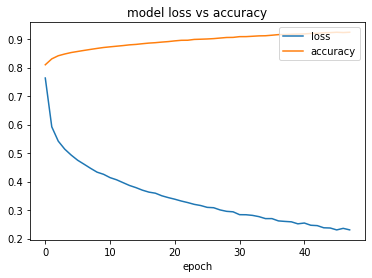

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('model loss vs accuracy')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'], loc='upper right')
plt.show()

In [ ]:
def remove_seq_padding(X, y_true, y_pred, pad=0):
    """Remove padding predictions from list of sequences"""
    new_true = []
    new_pred = []
    for sent_idx in range(len(X)):
        true_sent = []
        pred_sent = []
        for tok_idx in range(len(X[sent_idx])):
            if X[sent_idx][tok_idx] != pad:
                true_sent.append(y_true[sent_idx][tok_idx])
                pred_sent.append(y_pred[sent_idx][tok_idx])
        new_true.append(true_sent)
        new_pred.append(pred_sent)
    return np.array(new_true), np.array(new_pred)

In [ ]:
def from_encode_to_literal_labels(y_true, y_pred, idx2tag):
    '''Transform sequences of encoded labels in sequences of string labels'''
    let_y_true = list()
    let_y_pred = list()
    for sent_idx in range(len(y_true)):
        let_sent_true = []
        let_sent_pred = []
        for token_idx in range(len(y_true[sent_idx])):
            let_sent_true.append(idx2tag[y_true[sent_idx][token_idx]])
            let_sent_pred.append(idx2tag[y_pred[sent_idx][token_idx]])
        let_y_true.append(let_sent_true)
        let_y_pred.append(let_sent_pred)

    return let_y_true, let_y_pred

In [ ]:
datasets = [('Training Set', X_train, Y_train), ('Test Set', X_test, Y_test)]
for title, X, Y in datasets:
    # we make predictions
    Y_pred_lstm = model.predict(X, batch_size=batch_size)
    Y_pred_lstm = np.array(np.argmax(Y_pred_lstm, axis=-1))
    Y = np.array(np.argmax(Y, axis=-1))
    Y, Y_pred = remove_seq_padding(X, Y, Y_pred_lstm)
    let_y_true_lstm, let_y_pred_lstm = from_encode_to_literal_labels(Y, Y_pred_lstm, idx2tag)
    # from a double list we make a single list according to the argument of classification report
    single_list_true_lstm = []
    single_list_pred_lstm = []
    for i in range(len(let_y_true_lstm)):
      for j in range(len(let_y_true_lstm[i])):
        single_list_true_lstm.append(let_y_true_lstm[i][j])
    for i in range(len(let_y_pred_lstm)):
      for j in range(len(let_y_pred_lstm[i])):
       single_list_pred_lstm.append(let_y_pred_lstm[i][j])
    print(title)
    print(classification_report(single_list_pred_lstm, single_list_true_lstm))




250/250 [==============================] - 2s 4ms/step
Training Set
                precision    recall  f1-score   support

    B-abstract       0.76      0.78      0.77      1917
      B-animal       0.72      0.79      0.75       127
       B-event       0.53      0.75      0.62       525
      B-object       0.78      0.86      0.82       920
B-organization       0.74      0.88      0.80       336
      B-person       0.95      0.84      0.89      2164
       B-place       0.83      0.83      0.83      1148
       B-plant       0.91      0.83      0.87       158
    B-quantity       0.77      0.76      0.77        99
   B-substance       0.82      0.80      0.81       286
        B-time       0.90      0.77      0.83       462
    I-abstract       0.75      0.92      0.83      3807
      I-animal       0.94      0.81      0.87       138
       I-event       0.72      0.92      0.81      2118
      I-object       0.81      0.93      0.87      1511
I-organization       0.84      0.91

From the classification report: \
Firstly we notice that there is much difference between Training and Test in terms of  values of **precision and recall**  and this we can attribute to the **Class Imbalance**.

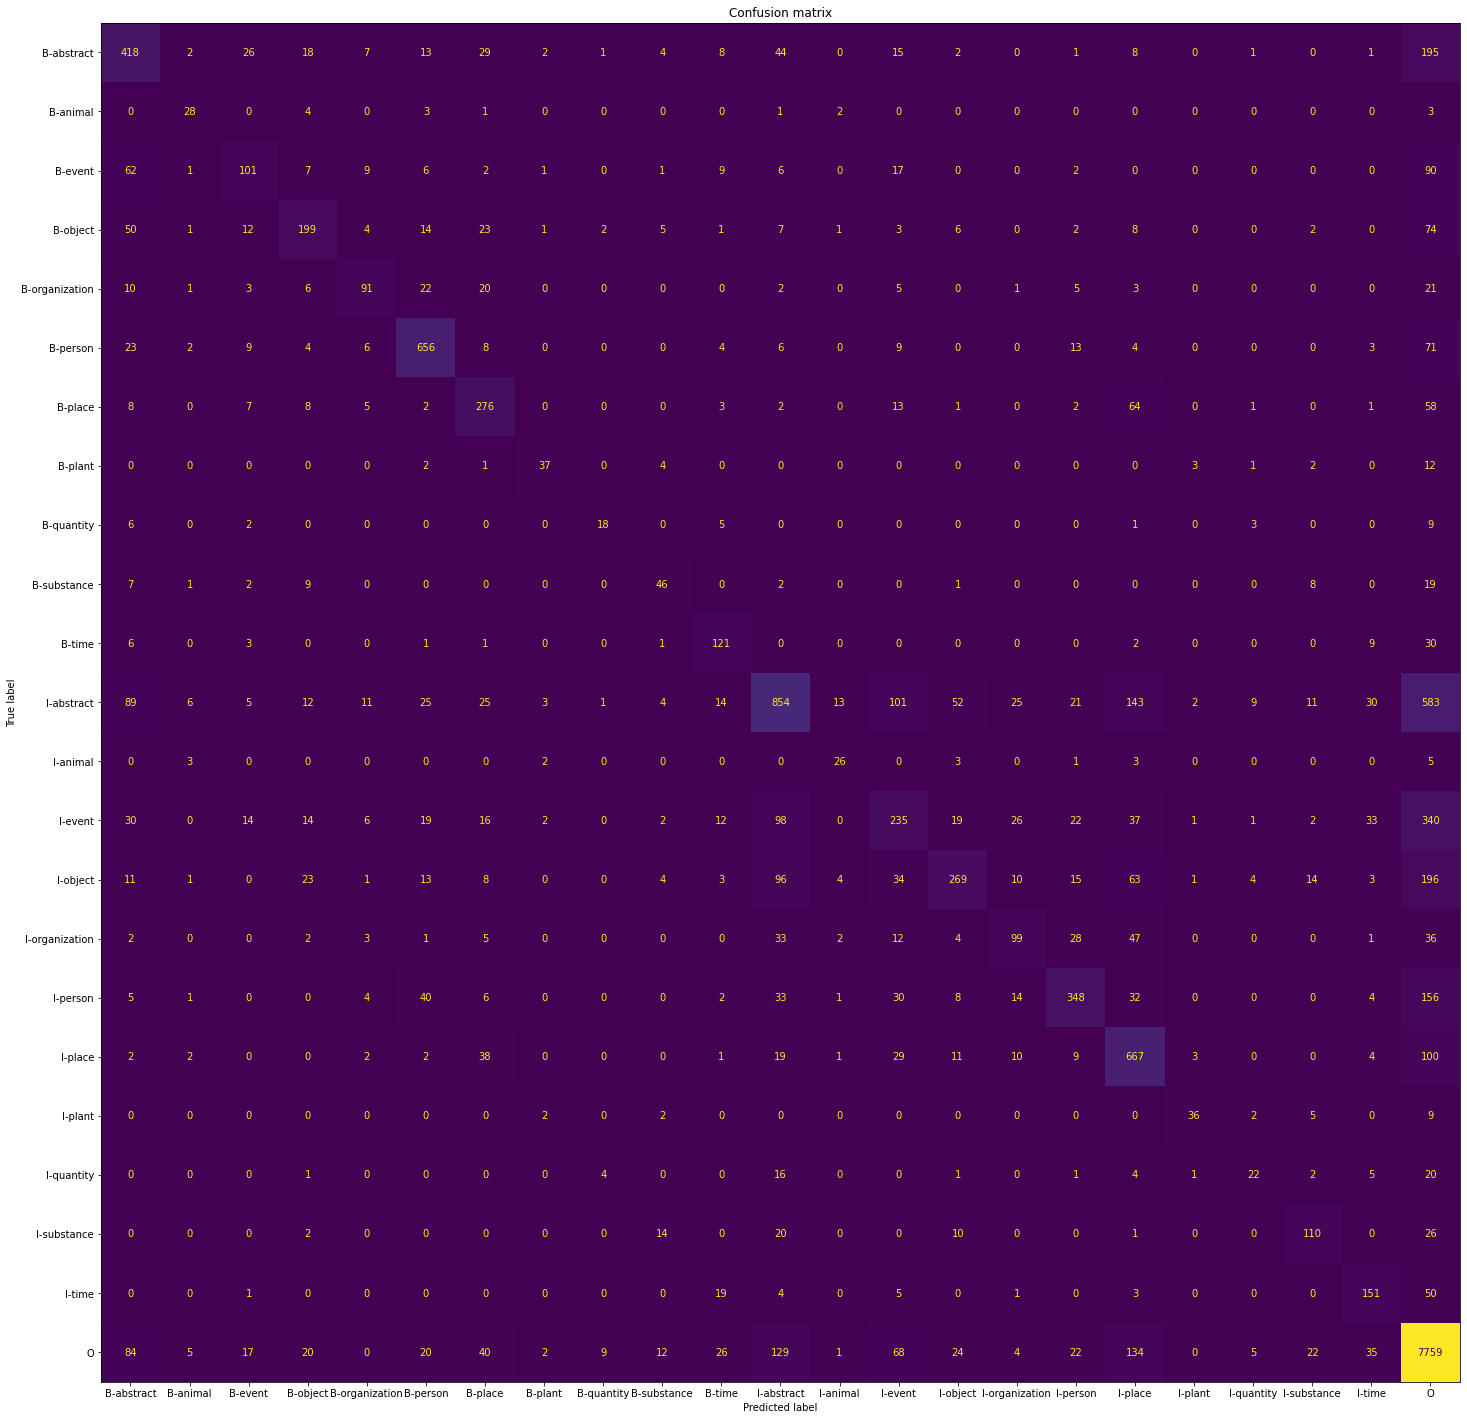

In [ ]:
classes= ['B-abstract','B-animal','B-event','B-object','B-organization','B-person','B-place','B-plant','B-quantity',
          'B-substance','B-time','I-abstract','I-animal','I-event','I-object','I-organization','I-person','I-place',
          'I-plant','I-quantity','I-substance','I-time','O']

def plot_confusion_matrix(y_preds, y_true, classes):
    cm = confusion_matrix(y_true, y_preds)
    fig, ax = plt.subplots(figsize=(25, 25))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels= classes)
    disp.plot( ax=ax, colorbar=False)
    plt.title("Confusion matrix")
    plt.show()


# calculated on test set
plot_confusion_matrix(single_list_pred_lstm, single_list_true_lstm, classes)

### 5.2 BERT

We apply Bert (Bidirectional Encoder Representations from Transformers) that is a pre-training transformer-based machine learing technique.

In [ ]:
def adj_label(texts, labels):
    #Adjust lables that after tokenisation are out of phase.
    tokenized_inputs = tokenizer(texts, padding='max_length', max_length=512, truncation=True)

    word_ids = tokenized_inputs.word_ids()

    previous_word_idx = None
    label_ids = []

    for word_idx in word_ids:

        if word_idx is None:
            label_ids.append(-100)

        elif word_idx != previous_word_idx:
            try:
                label_ids.append(labels_to_ids[labels[word_idx]])
            except:
                label_ids.append(-100)
        else:
            try:
                label_ids.append(labels_to_ids[labels[word_idx]] if label_all_tokens else -100)
            except:
                label_ids.append(-100)
        previous_word_idx = word_idx

    return label_ids

In [ ]:
class DataSequence(torch.utils.data.Dataset):
    # Initialize a class DataSequence to apply tokenization and the function adj_label.
    def __init__(self, df_train):

        lb = [i.split() for i in df_train['label'].values.tolist()]
        txt = df_train['text'].values.tolist()
        self.texts = [tokenizer(str(i),padding='max_length', max_length = 512, truncation=True, return_tensors="pt") for i in txt]
        self.labels = [adj_label(i,j) for i,j in zip(txt, lb)]

    def __len__(self):

        return len(self.labels)

    def get_batch_data(self, idx):

        return self.texts[idx]

    def get_batch_labels(self, idx):

        return torch.LongTensor(self.labels[idx])

    def __getitem__(self, idx):

        batch_data = self.get_batch_data(idx)
        batch_labels = self.get_batch_labels(idx)

        return batch_data, batch_labels

In [ ]:
class BertModel(torch.nn.Module):
    # Initialize a class Bert to create a model.
    def __init__(self):

        super(BertModel, self).__init__()

        self.bert = BertForTokenClassification.from_pretrained('bert-base-cased', num_labels=len(output_labels))

    def forward(self, input_id, mask, label):

        output = self.bert(input_ids=input_id, attention_mask=mask, labels=label, return_dict=False)

        return output

In [ ]:
def training_model(model, train, validate, batch_size, learning_rate, epochs):

    train_dataset = DataSequence(train)
    val_dataset = DataSequence(validate)

    train_dataloader = DataLoader(train_dataset, num_workers=4, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, num_workers=4, batch_size=batch_size)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    optimizer = SGD(model.parameters(), lr=learning_rate)

    if use_cuda:
        model = model.cuda()

    best_acc = 0
    best_loss = 1000

    for epoch_num in range(epochs):

        total_acc_train = 0
        total_loss_train = 0

        model.train()
        for train_data, train_label in tqdm(train_dataloader):

            train_label = train_label.to(device)
            mask = train_data['attention_mask'].squeeze(1).to(device)
            input_id = train_data['input_ids'].squeeze(1).to(device)

            optimizer.zero_grad()
            loss, logits = model(input_id, mask, train_label)

            for i in range(logits.shape[0]):

              logits_clean = logits[i][train_label[i] != -100]
              label_clean = train_label[i][train_label[i] != -100]

              predictions = logits_clean.argmax(dim=1)
              acc = (predictions == label_clean).float().mean()
              total_acc_train += acc
              total_loss_train += loss.item()

            loss.backward()
            optimizer.step()

        model.eval()

        total_acc_val = 0
        total_loss_val = 0

        for val_data, val_label in val_dataloader:

            val_label = val_label.to(device)
            mask = val_data['attention_mask'].squeeze(1).to(device)
            input_id = val_data['input_ids'].squeeze(1).to(device)

            loss, logits = model(input_id, mask, val_label)

            for i in range(logits.shape[0]):

              logits_clean = logits[i][val_label[i] != -100]
              label_clean = val_label[i][val_label[i] != -100]

              predictions = logits_clean.argmax(dim=1)
              acc = (predictions == label_clean).float().mean()
              total_acc_val += acc
              total_loss_val += loss.item()

        val_accuracy = total_acc_val / len(validate)
        val_loss = total_loss_val / len(validate)

        print(
            f'EPOCH {epoch_num + 1}/{epochs} | TRAIN - Loss: {total_loss_train / len(train): .3f} ; Accuracy: {total_acc_train / len(train): .3f} | VALIDATE -  Loss: {total_loss_val / len(validate): .3f} ; Accuracy: {total_acc_val / len(validate): .3f}')

In [ ]:
def split_tvt(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [ ]:
def testing(model, test):

    test_dataset = DataSequence(test)
    test_dataloader = DataLoader(test_dataset, num_workers=4, batch_size=1)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0.0
    my_true = []
    my_pred = []
    for test_data, test_label in test_dataloader:

            test_label = test_label.to(device)

            mask = test_data['attention_mask'].squeeze(1).to(device)

            input_id = test_data['input_ids'].squeeze(1).to(device)

            loss, logits = model(input_id, mask, test_label)
            for i in range(logits.shape[0]):

              logits_clean = logits[i][test_label[i] != -100]
              label_clean = test_label[i][test_label[i] != -100]
              predictions = logits_clean.argmax(dim=1)

              label_clean_cpu = label_clean.cpu()
              my_true.append(list(label_clean_cpu.numpy()))

              predictions_cpu = predictions.cpu()
              my_pred.append(list(predictions_cpu.numpy()))

              acc = (predictions == label_clean).float().mean()
              total_acc_test += acc

    test_accuracy = total_acc_test / len(test)
    return my_true, my_pred

We create a unique pandas dataframe that is readble by Bert, after that we split it into train,valid,test.

In [ ]:
raw_text = []
for i in range(len(raw_train)):
  current_string = ""
  for j in range(len(raw_train[i])):
    current_string = current_string + " " + raw_train[i][j]
  raw_text.append(current_string)
raw_labels = []
for i in range(len(raw_train)):
  current_string = ""
  for j in range(len(raw_train[i])):
    current_string = current_string + " " + ner_train[i][j]
  raw_labels.append(current_string)
train_list = []
for i in range(len(raw_train)):
  train_list.append([raw_text[i], raw_labels[i]])
temp_train = pd.DataFrame (train_list, columns = ['text', 'label'])
temp_train

,text,label
0,"The back of my jersey says "" The Poet ' becau...",B-object I-object I-object I-object I-object ...
1,"These hotels may not be the most luxerious , ...",B-place I-place O O O O O O O O O O O B-abstr...
2,Henga Scenic Reserve .,B-place I-place I-place O
3,It costs us so much money to for us to travel...,B-abstract O B-organization O O O O B-abstrac...
4,Tulsa has over 225 days of sunshine annually .,B-place O B-quantity I-quantity I-quantity I-...
...,...,...
2489,"Come and have a look at this statue , erected...",O O O B-event I-event I-event I-event I-event...
2490,""" If an infant 's not getting enough iodine ....",O O B-person I-person O O O B-substance I-sub...
2491,If you cannot go to the Cuban Consulate you m...,O B-person O O O B-organization I-organizatio...
2492,Steps,B-abstract


In [ ]:
raw_text = []
for i in range(len(raw_test)):
  current_string = ""
  for j in range(len(raw_test[i])):
    current_string = current_string + " " + raw_test[i][j]
  raw_text.append(current_string)
raw_labels = []
for i in range(len(raw_test)):
  current_string = ""
  for j in range(len(raw_test[i])):
    current_string = current_string + " " + ner_test[i][j]
  raw_labels.append(current_string)
train_list = []
for i in range(len(raw_test)):
  train_list.append([raw_text[i], raw_labels[i]])
temp_test = pd.DataFrame (train_list, columns = ['text', 'label'])
temp_test

,text,label
0,"Pacific Standard owner , Jonathan M. Stan , d...",B-person I-person I-person O B-person I-perso...
1,Focus your list on including the things you t...,O B-object I-object O O B-abstract I-abstract...
2,we started working with a few of our friends ...,B-person O O O B-person I-person I-person I-p...
3,Basalt columns,B-object I-object
4,Image : Danny Newman .,B-object O B-person I-person O
...,...,...
994,Draw a line in front of its beak instead .,O B-object I-object O B-place I-place I-place...
995,A Connecticut Yankee in King Arthur 's Court ...,B-object I-object I-object I-object I-object ...
996,"Now that we ’re in 2011 , in an era of modern...",O O B-person O O B-time O O B-time I-time I-t...
997,The creators of Muggle Quidditch thought that...,B-person I-person I-person I-person I-person ...


In [ ]:
labels_to_ids = {k: v for v, k in enumerate(sorted(output_labels))}
ids_to_labels = {v: k for v, k in enumerate(sorted(output_labels))}

In [ ]:
df = pd.merge(temp_train,temp_test,how='outer')
print('Df shape:', df.shape)

Df shape: (3510, 2)


In [ ]:
train, validate, test = split_tvt(df)

print('Train shape:', train.shape)
print('Validate shape:', validate.shape)
print('Test shape:',test.shape)

Train shape: (2106, 2)
Validate shape: (702, 2)
Test shape: (702, 2)


In [ ]:
model_ckpt = 'bert-base-cased'
tokenizer = BertTokenizerFast.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
bert = BertModel()

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [ ]:
training_model(bert, train, validate, learning_rate = 0.01, epochs = 6, batch_size = 4)

100%|██████████| 527/527 [03:22<00:00,  2.61it/s]


EPOCH 1/6 | TRAIN - Loss:  1.562 ; Accuracy:  0.566 | VALIDATE -  Loss:  1.179 ; Accuracy:  0.669


100%|██████████| 527/527 [03:21<00:00,  2.61it/s]


EPOCH 2/6 | TRAIN - Loss:  1.156 ; Accuracy:  0.683 | VALIDATE -  Loss:  1.114 ; Accuracy:  0.688


100%|██████████| 527/527 [03:22<00:00,  2.61it/s]


EPOCH 3/6 | TRAIN - Loss:  0.996 ; Accuracy:  0.726 | VALIDATE -  Loss:  1.048 ; Accuracy:  0.719


100%|██████████| 527/527 [03:21<00:00,  2.61it/s]


EPOCH 4/6 | TRAIN - Loss:  0.875 ; Accuracy:  0.753 | VALIDATE -  Loss:  1.025 ; Accuracy:  0.720


100%|██████████| 527/527 [03:22<00:00,  2.61it/s]


EPOCH 5/6 | TRAIN - Loss:  0.745 ; Accuracy:  0.790 | VALIDATE -  Loss:  1.039 ; Accuracy:  0.723


100%|██████████| 527/527 [03:22<00:00,  2.61it/s]


EPOCH 6/6 | TRAIN - Loss:  0.629 ; Accuracy:  0.823 | VALIDATE -  Loss:  1.090 ; Accuracy:  0.735


From the model we can see that in some epochs the Validation Accuracy is higher than Train Accuracy this is perhaps due to the capacity of our model to generalize when see unknown data.

In [ ]:
y_true, y_pred = testing(bert, test)
let_y_true_bert, let_y_pred_bert = from_encode_to_literal_labels(y_true, y_pred, ids_to_labels)

In [ ]:
single_list_true_bert = []
single_list_pred_bert = []
for i in range(len(let_y_true_bert)):
  for j in range(len(let_y_true_bert[i])):
    single_list_true_bert.append(let_y_true_bert[i][j])

for i in range(len(let_y_pred_bert)):
  for j in range(len(let_y_pred_bert[i])):
    single_list_pred_bert.append(let_y_pred_bert[i][j])

print(classification_report(single_list_pred_bert, single_list_true_bert))


                precision    recall  f1-score   support

    B-abstract       0.52      0.50      0.51       611
      B-animal       0.46      0.50      0.48        36
       B-event       0.35      0.62      0.45       130
      B-object       0.51      0.64      0.57       249
B-organization       0.50      0.57      0.53       104
      B-person       0.74      0.74      0.74       593
       B-place       0.53      0.64      0.58       275
       B-plant       0.61      0.51      0.56        49
    B-quantity       0.15      0.25      0.19        16
   B-substance       0.68      0.47      0.56        91
        B-time       0.53      0.65      0.58        88
    I-abstract       0.53      0.56      0.55      1421
      I-animal       0.79      0.51      0.62        43
       I-event       0.25      0.56      0.34       315
      I-object       0.41      0.58      0.48       355
I-organization       0.60      0.54      0.57       211
      I-person       0.78      0.74      0.76  

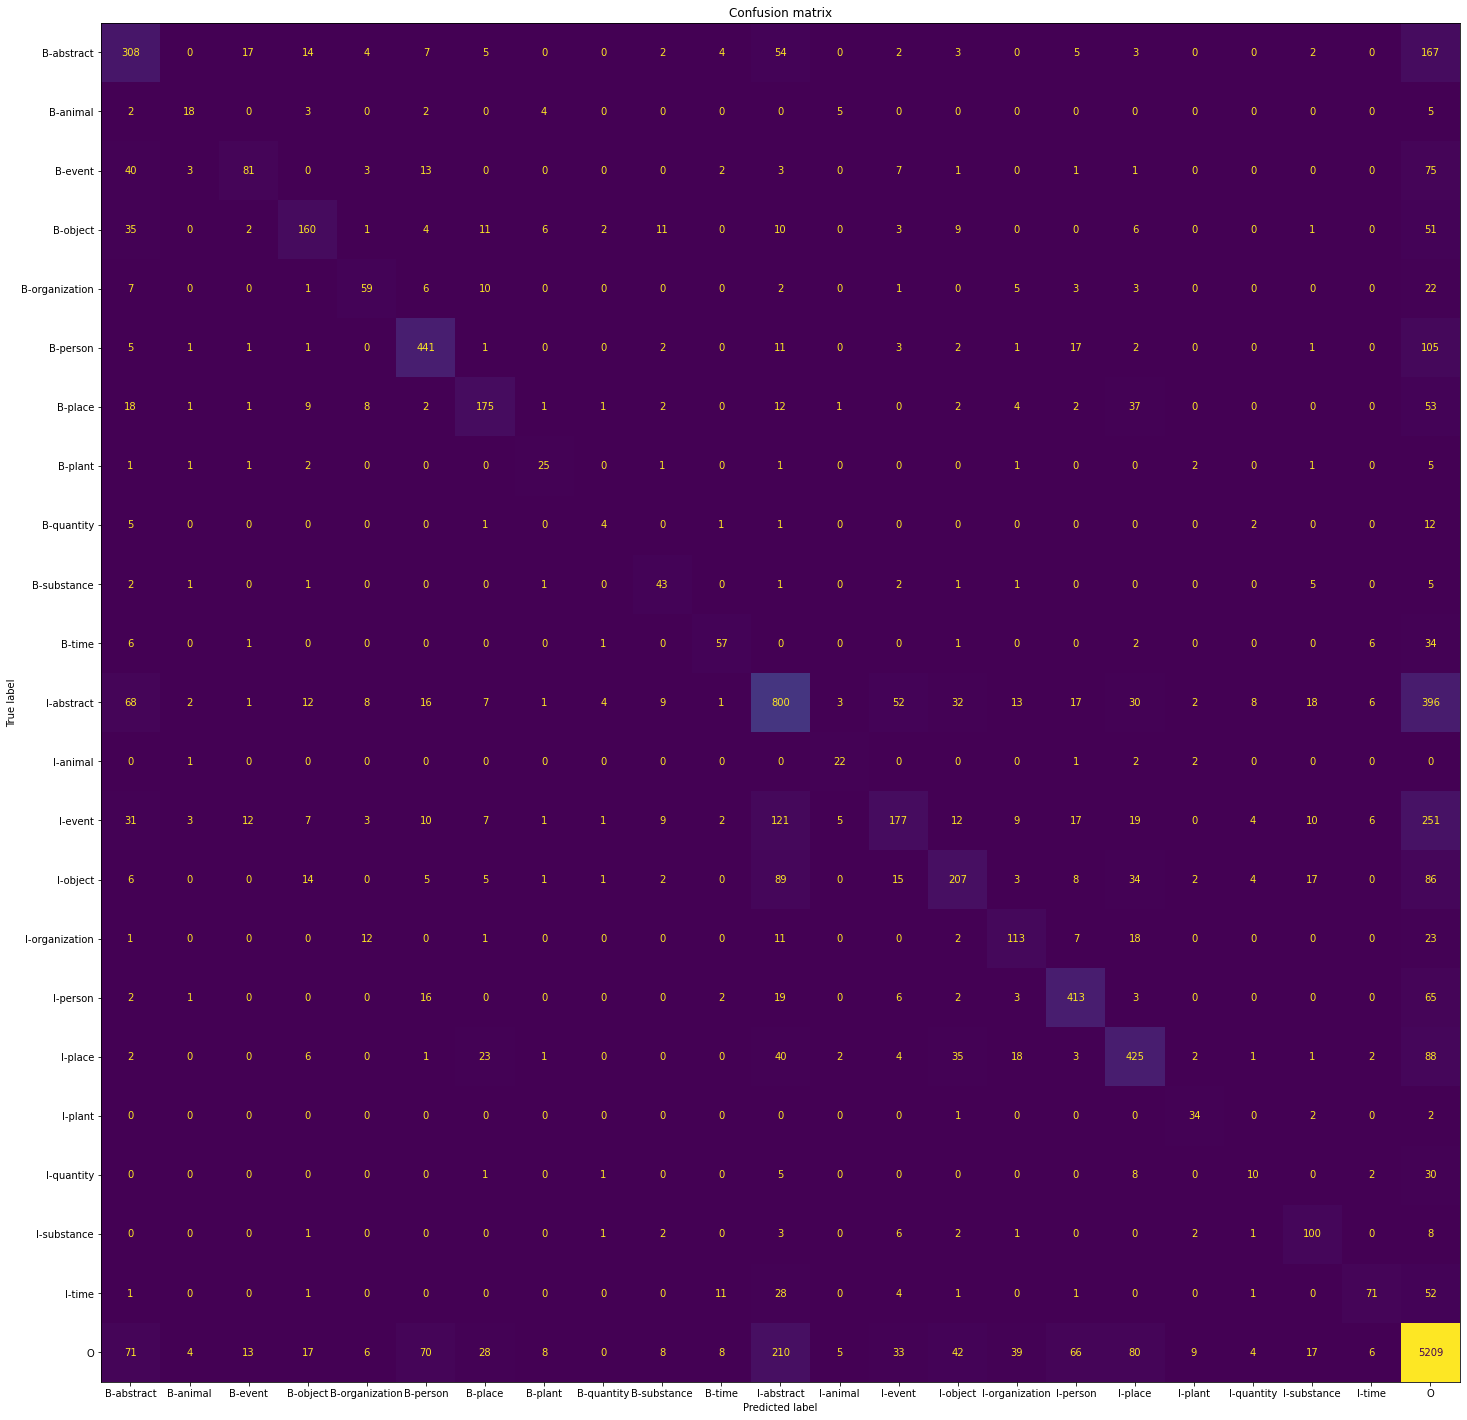

In [ ]:
plot_confusion_matrix(single_list_pred_bert, single_list_true_bert, classes)

## 6. Conclusion

We can notice that **BI-LSTM** performs better than as **BERT** with slighlty differences in terms of accuracy. \
Both Models suffers from Class Imbalance as we can see from classification report because same classes has low Precision and Recall. \
Instead from **Topic Modelling** view we can spot that there are not predominant Topics this is due to the fact that our corpus is heterogeneous.